In [1]:
import cv2
import matplotlib.pyplot as plt
import torch

import Inference
import Filter
import rrrc_cpp

# https://github.com/qbxlvnf11/convert-pytorch-onnx-tensorrt/blob/TensorRT-21.08/convert_onnx_to_tensorrt/convert_onnx_to_tensorrt.py

In [2]:
img = cv2.imread("/home/artl2sch/Desktop/Robotic_Perception/C++/FastCropRotate/0-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, [2000, 2000])

In [3]:
out_n = 250

with torch.no_grad():    

    input_image  =  torch.tensor(img, dtype = torch.uint8)[None, :, :].contiguous().cuda()
    output_images = torch.zeros([out_n, 1, 128, 128], dtype = torch.float32).contiguous().cuda()

    M = torch.tensor([1.0, 0.0, 0.0, 1.0]*out_n, dtype = torch.float32)
    M_rand = torch.rand_like(M)
    M += M_rand * 0.5

    M *= input_image.shape[-1]/output_images.shape[-1]
    T = torch.tensor([0.0, 0.0]*out_n, dtype = torch.float32)

In [4]:
'''import SimCLR
import yaml
import time
import torch
with open('./config.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

model = SimCLR.load_saved_model(config)
model.to('cuda')
model.eval()

#output_images = torch.zeros([500, 1, 128, 128], dtype = torch.float32).contiguous().cuda()

'''

"import SimCLR\nimport yaml\nimport time\nimport torch\nwith open('./config.yaml') as f:\n    config = yaml.load(f, Loader=yaml.Loader)\n\nmodel = SimCLR.load_saved_model(config)\nmodel.to('cuda')\nmodel.eval()\n\n#output_images = torch.zeros([500, 1, 128, 128], dtype = torch.float32).contiguous().cuda()\n\n"

In [5]:
'''t = 0
for i in range(100):
    output_images = torch.rand([400, 1, 128, 128], dtype = torch.float32).cuda()

    t -= time.time()
    output_images_3 = output_images.repeat(1, 3, 1, 1)
    model_out = model(output_images_3)
    t += time.time()

    del output_images
    del output_images_3


    torch.cuda.empty_cache()

print (t/100)'''

't = 0\nfor i in range(100):\n    output_images = torch.rand([400, 1, 128, 128], dtype = torch.float32).cuda()\n\n    t -= time.time()\n    output_images_3 = output_images.repeat(1, 3, 1, 1)\n    model_out = model(output_images_3)\n    t += time.time()\n\n    del output_images\n    del output_images_3\n\n\n    torch.cuda.empty_cache()\n\nprint (t/100)'

In [6]:
ONNX_FILE_PATH = './Weights/model.onnx'
with torch.no_grad():    
    trt_model = Inference.TRTModel(out_n, ONNX_FILE_PATH)
    trt_model.build_engine()
    trt_model.reserve_cuda_memory()

[07/02/2023-17:42:03] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[07/02/2023-17:42:03] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
inputTensor.name: input
[07/02/2023-17:42:32] [TRT] [W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[07/02/2023-17:42:32] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magnitude of the weights.
[07/02/2023-17:42:32] [TRT] [W] Check verbose logs for the list of affected weights.
[07/02/2023-17:42:32] [TRT] [W] - 24 weights are affected by this issue: Detected subnormal FP16 values.
[07/02/20

In [7]:
with torch.no_grad():
    pf = Filter.ParticleFilter(out_n)
    displacement_val = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype = torch.float32).cuda()
    displacement_var = torch.tensor([0.5, 0.0, 0.0, 0.2], dtype = torch.float32).cuda()

In [16]:
n_steps = 70

import time


loop_time = -time.time()

rrrc_time = 0
pf_time = 0
model_time = 0

for i in range(n_steps):
    with torch.no_grad():    

        rrrc_time -= time.time()
        
        rrrc_cpp.rrrc(input_image, output_images, M, T) # in a loop with input images
        
        rrrc_time += time.time()

        model_time -= time.time()
        output_images_3 = output_images.repeat(1, 3, 1, 1)
        embeddings = trt_model.run(output_images_3)
        model_time += time.time()

        pf_time -= time.time()
        pf.resample(embeddings) # add weighted average for particles
        pf.move(displacement_val, displacement_var) # should be parallel with the loop

        geo_particles = pf.to_geodetic([31.884542,  34.961650,  0])

        # generate M, T and update 

        pf_time += time.time()



loop_time += time.time()

loop_time /= n_steps
rrrc_time /= n_steps
model_time /= n_steps
pf_time /= n_steps


print ("model input : ", output_images_3.shape)
print ("loop  time : ", loop_time)
print ("rrrc  time : ", rrrc_time)
print ("model time : ", model_time)
print ("pf    time : ", pf_time)

model input :  torch.Size([250, 3, 128, 128])
loop  time :  0.013764987673078264
rrrc  time :  0.0020873546600341797
model time :  0.01061974252973284
pf    time :  0.0010360751833234515


In [17]:
#pf.draw_particles()
pf.print_times()

init time :  0.0074961185455322266
move time :  0.0003445477712722052
resample time :  0.0003009977794828869
coord transform time :  0.0004285136858622233


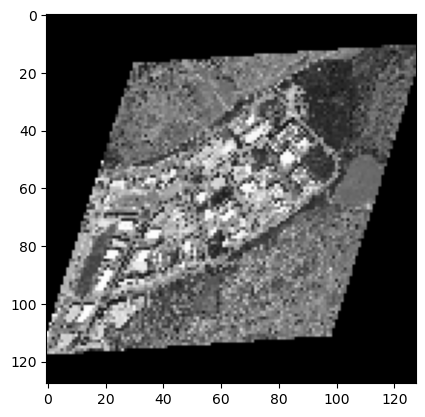

In [15]:
import numpy as np
plt.imshow(output_images_3[2].cpu().numpy().swapaxes(0, 2).astype(np.uint8))

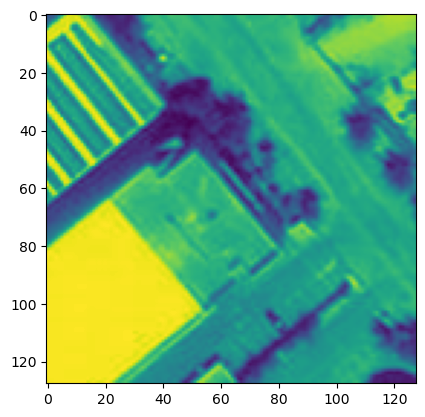

In [48]:
plt.imshow(input_image.cpu()[:, 1000:1128:1, 1000:1128:1].numpy().swapaxes(0, 2))

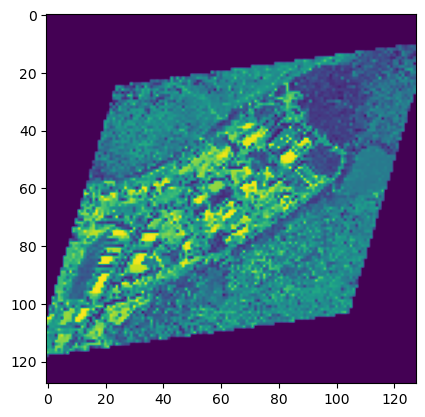

In [54]:
image = output_images[2].cpu().numpy().swapaxes(0, 2)

plt.imshow(output_images[2].cpu().numpy().swapaxes(0, 2))

In [53]:
image_3 = output_images_3[2].cpu().numpy().swapaxes(0, 2)

In [52]:
image_3.mean(), image.mean()

(70.88257, 70.88257)

In [19]:
a = [0, 1, 2, 3]

In [20]:
del a[0]

In [22]:
a.insert(0, 1)

In [23]:
a

[1, 1, 2, 3]

In [29]:
from ViewGenerator import MapView
import time

In [47]:
a = np.array([0.5, 1.5, 2.5, 3.5, 4.5])

In [48]:
np.round(a)

array([0., 2., 2., 4., 4.])

In [58]:
a.astype(str)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [60]:
np.char.replace(a.astype(str), '.', '-')

array(['0-5', '1-5', '2-5', '3-5', '4-5'], dtype='<U3')

In [1]:
import torch
import numpy as np
from FastCropRotate import FCR
import matplotlib.pyplot as plt

In [2]:
fcr = FCR()

In [3]:
fcr.set_coordinates(np.array([[0, 0, 0, 0]]))

In [4]:
fcr.region_ids_pixels_from_coordinates()
fcr.update_region_images()
fcr.calculate_M_T()

image shape :  (1972, 1973)


In [5]:
fcr.set_outputs()
fcr.region_dict['0-0']['output'].shape

torch.Size([1, 1, 1000, 1000])

id :  0-0
input :  torch.Size([1, 1972, 1973])   torch.uint8
output :  torch.Size([1, 1, 1000, 1000])   torch.float32
M :  torch.Size([4])   torch.float32
T :  torch.Size([2])   torch.float32


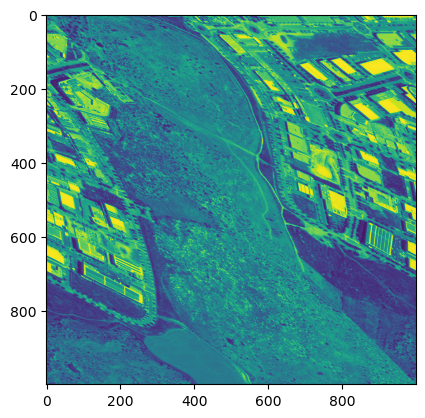

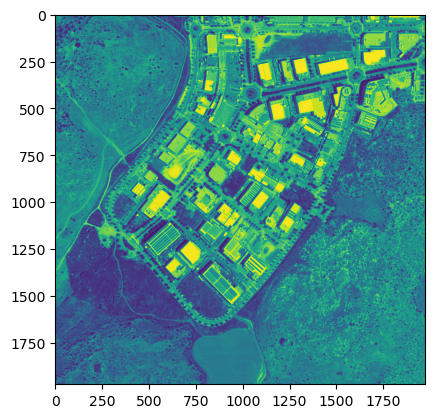

0.49739551544189453


In [6]:
import time
t = time.time()

fcr.fcr()

print (time.time() - t)

In [7]:
fcr.region_dict['0-0']['output']

tensor([[[[141., 155., 159.,  ..., 146., 116., 134.],
          [147., 141., 151.,  ..., 104., 108., 115.],
          [113., 120., 149.,  ...,  55.,  81.,  72.],
          ...,
          [ 88.,  79.,  81.,  ..., 127.,  84.,  83.],
          [ 81.,  96.,  92.,  ..., 116., 137.,  76.],
          [ 95.,  87.,  63.,  ..., 128., 148., 131.]]]], device='cuda:0')

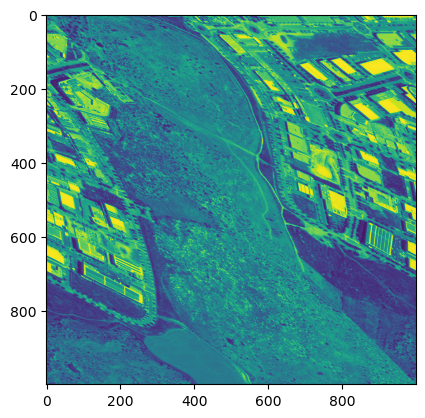

In [8]:
import matplotlib.pyplot as plt

plt.imshow(fcr.region_dict['0-0']['output'][0].cpu().numpy()[0])

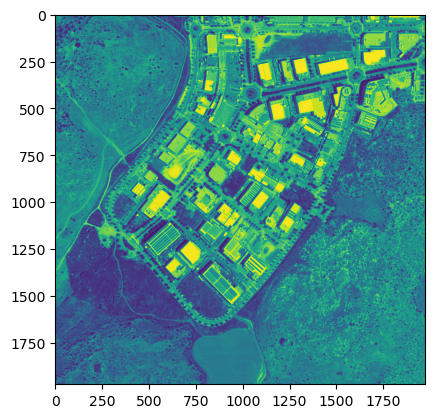

In [9]:
plt.imshow(fcr.region_dict['0-0']['input'].cpu().numpy()[0])